# Introduction to Data Science – Lecture 14 – APIs
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecture we will explore how we can extract data from web-APIs. The first part of this tutorial is based on [this blog](https://www.dataquest.io/blog/python-api-tutorial/).

API stands for Application Programming Interface. It is supposed to be a **well defined interface** for consuming data (in contrast to web-scraping), or, more generally, for the **interaction with a remote program** on a server. APIs aren't only generated so that you can read data; they're often designed so that you could write custom software to interact with the API. You could, for example, write your own twitter client! 

APIs are usually well documented, as the organization that provides APIs wants you to use them. 

Here are a couple of examples of sites that have documented APIs:

 * [StackExchange](https://api.stackexchange.com/docs)  
 * [Twitter](https://dev.twitter.com/rest/public)
 * [Facebook](https://developers.facebook.com/docs/graph-api)
 * [KEGG](http://www.genome.jp/kegg/rest/keggapi.html) 
 * [Google Maps](https://developers.google.com/maps/) 
 * and many many more. 
 
Most APIs require some form of authentication and have rules on what you're allowed to do and what not. Follow those rules, or you will be blocked faster than you can say `GET`. 
 
Working with an API is a lot like working with a website, but instead of a human in front of the screen, it's computers talking to each other. 

We'll be using the dominant form of APIs on the web: REST (REpresentational State Transfer). REST APIs use an [URI](https://en.wikipedia.org/wiki/Uniform_Resource_Identifier) (a Uniform Resource Identifier; URLs are one specific form of URIs) to specify what you want to do with and API.

All API methods in REST are relative to a base URL. E.g., for twitter this would be
```
https://api.twitter.com/1.1/
```

A query would look like this: 

```
https://api.twitter.com/1.1/search/tweets.json?q=%40twitterapi
```


REST APIs can return data in different forms. The most common ones are JSON and XML, and of those two, JSON is now dominant. 

JSON stands for JavaScript Object Notation, and is a pretty convenient format, as we'll see. 
 

Let's start with a very simple example, retrieving the current position of the ISS. We will be using the [requests library](http://www.python-requests.org/en/latest/), which will handle our communication with the server.

In [1]:
import requests 
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get("http://api.open-notify.org/iss-now.json")

response

<Response [200]>

That looks good, we've received a response with the message "200". What does the 200 mean? It's a status code - you've probably seen the "Error 404" on the internet. 

Here are a couple of codes:

 * **200** – everything went okay, and the result has been returned (if any)
 * **301** – the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
 * **401** – the server thinks you’re not authenticated. This happens when you don’t send the right credentials to access an API (we’ll talk about authentication later).
 * **400** – the server thinks you made a bad request. This can happen when you don’t send along the right data, among other things.
 * **403** – the resource you’re trying to access is forbidden – you don’t have the right permissions to see it.
 * **404** – the resource you tried to access wasn’t found on the server.

Let's try to get a response with a wrong URL:

In [2]:
response_failed = requests.get("http://api.open-notify.org/iss")

response_failed

<Response [400]>

We used the get methods to put in a GET request. There are four different types of requests: 

![Request types](requests.png)
[Source](https://en.wikipedia.org/wiki/Representational_state_transfer)

Let's look at the payload of our previous, successful response:

In [3]:
response.content

b'{"timestamp": 1614709629, "message": "success", "iss_position": {"longitude": "101.8463", "latitude": "32.5211"}}'

We can already see that this is JSON (though it is stored a `bytes` object), but we can check formally:

In [4]:
response.headers['content-type']

'application/json'

We can decode this byte object, then the JSON will be readable. 

In [5]:
response_j = response.content.decode("utf-8")
print(response_j)

{"timestamp": 1614709629, "message": "success", "iss_position": {"longitude": "101.8463", "latitude": "32.5211"}}


Let's take a look at the JSON with nice formatting here:

```JSON
{
  "timestamp": 1475240215,
  "message": "success", 
  "iss_position": {
    "latitude": -30.005751854107206, 
    "longitude": -104.20085371352678
  } 
}
```

This looks a lot like a dictionary (or objects, for that matter)! We have key-value pairs. 

We can use the [json library](https://docs.python.org/3/library/json.html) to convert JSON into objects:

In [6]:
import json
response_d = json.loads(response_j)
print(type(response_d))
print(response_d)
response_d["iss_position"]

<class 'dict'>
{'timestamp': 1614709629, 'message': 'success', 'iss_position': {'longitude': '101.8463', 'latitude': '32.5211'}}


{'longitude': '101.8463', 'latitude': '32.5211'}

Or, not surprisingly, pandas can also load a json object:

In [7]:
import pandas as pd 

df = pd.read_json(response_j)
df

,timestamp,message,iss_position
latitude,2021-03-02 18:27:09,success,32.5211
longitude,2021-03-02 18:27:09,success,101.8463


This isn't quite what we want - we probably want one row per timestamp and longitude and latitude as columns:

In [8]:
def flatten(response_d):
    response_flat = {}
    response_flat["latitude"] = response_d["iss_position"]["latitude"]
    response_flat["longitude"] = response_d["iss_position"]["longitude"]
    response_flat["timestamp"] = response_d["timestamp"]
    return response_flat
flatten(response_d)

{'latitude': '32.5211', 'longitude': '101.8463', 'timestamp': 1614709629}

That looks better. Let's get a couple of positions of the ISS over time and save it as an array:

In [9]:
import time

def pull_position():
    """Retreives the position of the ISS and returns it as a flat dictionary"""
    response = requests.get("http://api.open-notify.org/iss-now.json")
    response_j = response.content.decode("utf-8")
    response_d = json.loads(response_j)
    flat_response = flatten(response_d)
    return flat_response    

iss_position = []
    
# calls pull_position 10 times with 3 seconds break
for i in range(10):
    flat_response = pull_position()
    iss_position.append(flat_response)
    print(flat_response)
    time.sleep(3)
    
len(iss_position)

{'latitude': '32.5649', 'longitude': '101.8987', 'timestamp': 1614709630}
{'latitude': '32.6964', 'longitude': '102.0563', 'timestamp': 1614709633}
{'latitude': '32.8276', 'longitude': '102.2143', 'timestamp': 1614709636}
{'latitude': '32.9586', 'longitude': '102.3728', 'timestamp': 1614709639}
{'latitude': '33.1111', 'longitude': '102.5584', 'timestamp': 1614709643}
{'latitude': '33.2415', 'longitude': '102.7181', 'timestamp': 1614709646}
{'latitude': '33.3717', 'longitude': '102.8782', 'timestamp': 1614709649}
{'latitude': '33.5017', 'longitude': '103.0389', 'timestamp': 1614709652}
{'latitude': '33.6315', 'longitude': '103.2001', 'timestamp': 1614709655}
{'latitude': '33.7610', 'longitude': '103.3618', 'timestamp': 1614709658}


10

Now we can convert this into a nice dataframe:

In [10]:
iss_position_df = pd.DataFrame(iss_position)
iss_position_df['timestamp']  = pd.to_datetime(iss_position_df['timestamp'], unit="s")

iss_position_df = iss_position_df.set_index(pd.DatetimeIndex(iss_position_df['timestamp']))
iss_position_df["latitude"] = iss_position_df["latitude"].map(float)
iss_position_df["longitude"] = iss_position_df["longitude"].map(float)
iss_position_df

,latitude,longitude,timestamp
timestamp,,,
2021-03-02 18:27:10,32.5649,101.8987,2021-03-02 18:27:10
2021-03-02 18:27:13,32.6964,102.0563,2021-03-02 18:27:13
2021-03-02 18:27:16,32.8276,102.2143,2021-03-02 18:27:16
2021-03-02 18:27:19,32.9586,102.3728,2021-03-02 18:27:19
2021-03-02 18:27:23,33.1111,102.5584,2021-03-02 18:27:23
2021-03-02 18:27:26,33.2415,102.7181,2021-03-02 18:27:26
2021-03-02 18:27:29,33.3717,102.8782,2021-03-02 18:27:29
2021-03-02 18:27:32,33.5017,103.0389,2021-03-02 18:27:32
2021-03-02 18:27:35,33.6315,103.2001,2021-03-02 18:27:35


Let's see how the ISS moves

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

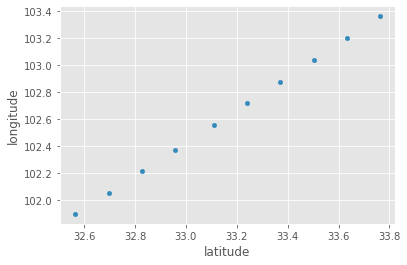

In [11]:
import matplotlib.pyplot as plt
# This next line tells jupyter to render the images inline
%matplotlib inline
plt.style.use('ggplot')
iss_position_df.plot(kind="scatter", x="latitude", y="longitude")

### Querying with Parameters

Requests can be parametrized. You can search for tweets of a specific user, for example, or [retrieve the time the ISS is over SLC](http://open-notify.org/Open-Notify-API/ISS-Pass-Times/)!

The way to query with a get request for the ISS is this:

`http://api.open-notify.org/iss-pass.json?lat=40.758701&lon=-111.876183`

We, of course, could generate that URL ourselves, but the requests library is helpful here. Since JSON is similar to dictionaries, the requests library takes dictionaries for parameters.

In [12]:
url = "http://api.open-notify.org/iss-pass.json"
coordinates = {"lat": 40.758701, "lon": -111.876183, "n":5}

r = requests.get(url, params=coordinates)
data = r.json()
data

{'message': 'success',
 'request': {'altitude': 100,
  'datetime': 1614709232,
  'latitude': 40.758701,
  'longitude': -111.876183,
  'passes': 5},
 'response': [{'duration': 617, 'risetime': 1614759566},
  {'duration': 641, 'risetime': 1614765357},
  {'duration': 572, 'risetime': 1614771243},
  {'duration': 578, 'risetime': 1614777112},
  {'duration': 646, 'risetime': 1614782925}]}

In [13]:
timestamp = data["response"][0]["risetime"]
pd.to_datetime(timestamp,  unit="s")

Timestamp('2021-03-03 08:19:26')

So, the ISS will be above SLC tomorrow morning!